In [ ]:
!pip install transformers
!pip install tokenizers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 21.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 13

In [ ]:
import tensorflow as tf
import numpy as np
import sklearn
from sklearn import metrics
import transformers
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import matplotlib.pyplot as plt
import random
import seaborn as sn
import datasets 
from datasets import load_dataset
import pandas as pd


In [ ]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

batch_size=8 * tpu_strategy.num_replicas_in_sync
print('Batch size:', batch_size)
AUTOTUNE = tf.data.experimental.AUTOTUNE

Batch size: 64


In [ ]:
def load_train_test_val_data(name_dataset : str):

    data = load_dataset('silicone',name_dataset)
    train = pd.DataFrame(data['train'])
    test = pd.DataFrame(data['test'])
    val = pd.DataFrame(data['validation'])

    return train, test, val

In [ ]:
iemocap_train, iemocap_test, iemocap_val = load_train_test_val_data("iemocap")

Generating train split:   0%|          | 0/7213 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/805 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2021 [00:00<?, ? examples/s]

Dataset silicone downloaded and prepared to /root/.cache/huggingface/datasets/silicone/iemocap/1.0.0/af617406c94e3f78da85f7ea74ebfbd3f297a9665cb54adbae305b03bc4442a5. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
#on réduit la taille du dataset pour avoir un temps d'entraînement raisonnable

train = iemocap_train[['Utterance','Label']]
test = iemocap_test[['Utterance','Label']]
val = iemocap_val[['Utterance','Label']]

df = pd.concat([train,test,val])

In [ ]:
n_categories = len(df['Label'].unique())

In [ ]:
X = df[['Utterance']].to_numpy().reshape(-1)
y = df[['Label']].to_numpy().reshape(-1)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base") #Tokenizer
inputs = tokenizer(X.tolist(), padding=True, truncation=True, return_tensors='tf') #Tokenized text

In [ ]:
dataset=tf.data.Dataset.from_tensor_slices((dict(inputs), y))

In [ ]:
val_data_size=int(0.1*len(df))
val_ds=dataset.take(val_data_size).batch(batch_size, drop_remainder=True) 
train_ds=dataset.skip(val_data_size).batch(batch_size, drop_remainder=True)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
with tpu_strategy.scope():
    model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=n_categories)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")],
        )
 
history=model.fit(train_ds, validation_data=val_ds, epochs=20, verbose=1)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20
141/141 [==============================] - 99s 154ms/step - loss: 2.0644 - acc: 0.2213 - val_loss: 1.9425 - val_acc: 0.2625
Epoch 2/20
141/141 [==============================] - 16s 115ms/step - loss: 1.8421 - acc: 0.3030 - val_loss: 1.7498 - val_acc: 0.3333
Epoch 3/20
141/141 [==============================] - 16s 115ms/step - loss: 1.6524 - acc: 0.3944 - val_loss: 1.6453 - val_acc: 0.3729
Epoch 4/20
141/141 [==============================] - 16s 114ms/step - loss: 1.5019 - acc: 0.4548 - val_loss: 1.6120 - val_acc: 0.4000
Epoch 5/20
141/141 [==============================] - 16s 114ms/step - loss: 1.3684 - acc: 0.5073 - val_loss: 1.5962 - val_acc: 0.4052
Epoch 6/20
141/141 [==============================] - 17s 124ms/step - loss: 1.2746 - acc: 0.5401 - val_loss: 1.6036 - val_acc: 0.4125
Epoch 7/20
141/141 [==============================] - 16s 116ms/step - loss: 1.1981 - acc: 0.5687 - val_loss: 1.6345 - val_acc: 0.4031
Epoch 8/20
141/141 [==============================] - 1

In [ ]:
model.save_weights('./saved_weights_maptask.h5')


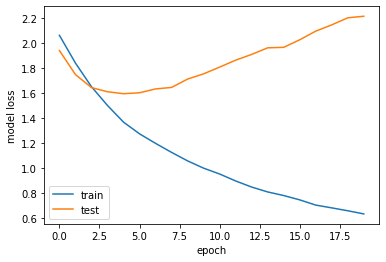

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('train_history.png')
plt.show()

# Validation loss is minimal with 6 epochs

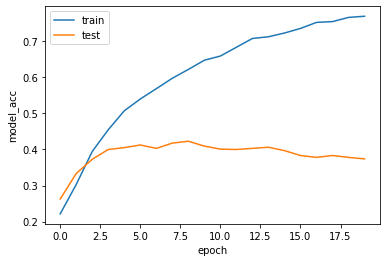

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model_acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('train_history.png')
plt.show()

# Validation accuracy is maximal with 9 epochs
